# Introduction:

This notebook will guide you through the process of building a basic recommender system for video games using the Steam dataset from Kaggle. We will leverage the machine learning concept such as cosine similarity to identify games that are similar to those a user has previously enjoyed. By the end of this tutorial, you will have a functional recommender system that can provide personalized game suggestions.

#Note:
This recommender system utilizes a simplified approach focusing on cosine similarity. There are more advanced techniques and algorithms that can be explored to enhance the system's accuracy and sophistication.

# Other Sources & References:
* https://www.kaggle.com/code/ugurokarapunar/game-recommendations-on-steam
* https://www.kaggle.com/code/vinayadatiya/game-recommendation-system
* https://www.kaggle.com/code/dongminkimm/steam-game-recommendations
* https://www.kaggle.com/code/dameertaheemgay/real-machine-learning-project-2
* https://www.kaggle.com/code/thakursankalp/steam-game-recommendation-engine
* https://www.kaggle.com/code/auradee/video-games-recommendation-system
* https://www.kaggle.com/code/jwyang91/steam-game-recommender
* https://www.kaggle.com/code/calven22/steam-recommender-system
* https://www.kaggle.com/code/mohamada2274/steam-video-games-recommendation
* https://www.kaggle.com/code/stpeteishii/steam-video-recommendation-lightfm
* https://www.kaggle.com/code/a3amat02/best-video-games-eda-and-game-recommendation
* https://www.kaggle.com/code/abhishekmanish/steam-games-dataset-eda-and-recommendation

# Import Modules

This section imports essential Python libraries for data manipulation, analysis, and machine learning. Pandas and NumPy enable efficient data handling and numerical computations. Libraries like mlxtend, sklearn, and scipy provide tools for frequent pattern mining, text vectorization, similarity calculations, and neighborhood-based methods used in the recommender system development. KaggleHub facilitates dataset retrieval from Kaggle directly within the Colab environment.

In [ ]:
# Install necessary packages
!pip install annoy
!pip install dask[dataframe]
!pip install implicit

# Import libraries
import dask.dataframe as dd
import gc
import implicit
import kagglehub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from annoy import AnnoyIndex
from dask import delayed
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import linear_kernel
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import csr_matrix
from scipy.sparse import coo_matrix

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Upload your Datasets

This project utilizes Steam datasets from Kaggle, varying in size and scope, to build a robust recommender system. These datasets contain information on games, users, recommendations, and ratings. Links to the Kaggle datasets are provided in the notebook for easy access. Ensure data is appropriately read into Pandas DataFrames for further processing.


* Size M: https://www.kaggle.com/datasets/antonkozyriev/game-recommendations-on-steam/data
* Size L: https://www.kaggle.com/datasets/whigmalwhim/steam-releases/data
* Size XL: https://www.kaggle.com/datasets/maestrocor/steam-games-and-user-playtime-data/data
* Size XL: https://www.kaggle.com/datasets/praffulsingh009/steam-video-games-2024


#Note
After multiple itteration, these dataset will not be used. But I would like to still keep them here for reference.
* https://www.kaggle.com/datasets/nikdavis/steam-store-games/data
* https://www.kaggle.com/datasets/shpadoinkle/steam-game-recommendation-ratings
* https://www.kaggle.com/datasets/mohamedtarek01234/steam-games-reviews-and-rankings?select=steam_game_reviews.csv
* https://www.kaggle.com/datasets/marcosparrasmolt/steam-library-metadata
* https://www.kaggle.com/datasets/bayuabdurrosyidyeye/steam-game-review?select=recommendations.csv
* https://www.kaggle.com/datasets/thedevastator/steam-games-user-statistics-and-features
* https://www.kaggle.com/datasets/mexwell/steamgames/data


In [ ]:
# Download CSV from Kaggle
path_1 = kagglehub.dataset_download("antonkozyriev/game-recommendations-on-steam")
path_2 = kagglehub.dataset_download("whigmalwhim/steam-releases")
path_3 = kagglehub.dataset_download("maestrocor/steam-games-and-user-playtime-data")
path_4 = kagglehub.dataset_download("praffulsingh009/steam-video-games-2024")

# List files in the downloaded directory
file_1 = os.listdir(path_1)
file_2 = os.listdir(path_2)
file_3 = os.listdir(path_3)
file_4 = os.listdir(path_4)
print("Files in the directory:", file_1)
print("Files in the directory:", file_2)
print("Files in the directory:", file_3)
print("Files in the directory:", file_4)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Files in the directory: ['users.csv', 'recommendations.csv', 'games_metadata.json', 'games.csv']
Files in the directory: ['games-release-ALL.csv', 'game_data_all.csv']
Files in the directory: ['user_game_played_data.csv', 'games.csv']
Files in the directory: ['Steam Games 2024.csv']


# DataFrames

This section focuses on loading the selected datasets into Pandas DataFrames, employing efficient memory management techniques. Functions like reduce_memory and data_generator are introduced to optimize memory usage, particularly for larger datasets. Each dataset is read into a separate DataFrame providing the foundation for subsequent data analysis and model building.
* df_games_1
* df_games_2
* df_games_3
* df_users
* df_recommendations

In [ ]:
# Function to reduce the memory usage of a DataFrame.
def reduce_memory(df):
    for col in df.columns:
        if df[col].dtype == 'float64':
            # Change to float32
            df[col] = df[col].astype('float32')
        if df[col].dtype == 'int64':
            # Change to int32
            df[col] = df[col].astype('int32')
        if df[col].dtype == 'object':
            # Exclude 'title' and 'genres'
            if col not in ['title', 'genres']:
                # Change to category
                df[col] = df[col].astype('category')
    return df

# Generator function to load data in chunks.
def data_generator(df, chunksize=10000):
    for i in range(0, df.shape[0], chunksize):
        yield df.iloc[i:i+chunksize]

# Now read the CSV file with the updated path
df_games_1 = reduce_memory(pd.read_csv(os.path.join(path_1, 'games.csv')))
df_games_2 = reduce_memory(pd.read_csv(os.path.join(path_2, 'game_data_all.csv')))
df_games_3 = reduce_memory(pd.read_csv(os.path.join(path_4, 'Steam Games 2024.csv')))
df_users = reduce_memory(pd.read_csv(os.path.join(path_3, 'user_game_played_data.csv')))
df_recommendations = reduce_memory(pd.read_csv(os.path.join(path_1, 'recommendations.csv')))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-3-34848f544c73>:25: DtypeWarning: Columns (0,4,5,6,7,8,17,18,19,20,22,23,24,25,26,27,29,30,31,32) have mixed types. Specify dtype option on import or set low_memory=False.
  df_games_3 = reduce_memory(pd.read_csv(os.path.join(path_4, 'Steam Games 2024.csv')))


# Data Analysis

This section performs preliminary data exploration to gain insights into the structure and characteristics of the datasets. It includes examining the shape (number of rows and columns), data types of each column, and overall information using functions like shape, dtypes, and info. Displaying the first few rows of each DataFrame using head() allows for a quick overview of the data's content, aiding in understanding its composition and potential relevance for building the recommender system. This initial analysis informs subsequent steps in data preprocessing and model development.

In [ ]:
# Analysize shape
print(df_games_1.shape)
print(df_games_2.shape)
print(df_games_3.shape)
print(df_users.shape)
print(df_recommendations.shape)

# Analysize dtypes
print(df_games_1.dtypes)
print(df_games_2.dtypes)
print(df_games_3.dtypes)
print(df_users.dtypes)
print(df_recommendations.dtypes)

# Analysize info
print(df_games_1.info())
print(df_games_2.info())
print(df_games_3.info())
print(df_users.info())
print(df_recommendations.info())

# Analyze columns
print(df_games_1.columns)
print(df_games_2.columns)
print(df_games_3.columns)
print(df_users.columns)
print(df_recommendations.columns)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(50872, 13)
(67571, 20)
(97428, 40)
(3197096, 3)
(41154794, 8)
app_id               int32
title               object
date_release      category
win                   bool
mac                   bool
linux                 bool
rating            category
positive_ratio       int32
user_reviews         int32
price_final        float32
price_original     float32
discount           float32
steam_deck            bool
dtype: object
Unnamed: 0                  int32
game                     category
link                     category
release                  category
peak_players                int32
positive_reviews            int32
negative_reviews            int32
total_reviews               int32
rating                    float32
primary_genre            category
store_genres             category
publisher                category
developer                category
detected_technologies    category
store_asset_mod_time     category
review_percentage         float32
players_right_now        cat

TT# Feature Engineering

The feature engineering process involved several crucial steps to prepare the data for the recommender system. First, irrelevant columns were removed from the datasets to streamline the data. Then, columns were renamed and reordered for consistency and to adjust data types. Multiple datasets (games.csv, steamgames.csv, and others) were strategically merged to create a comprehensive dataset combining game details with user information and play times. Finally, invalid and missing values were addressed to improve data quality. This thorough feature engineering ensured that the recommender system had access to essential information represented in a format suitable for model training.



In [ ]:
# Remove columns that are not needed
# Get a list of existing columns
existing_columns_df_games_1 = df_games_1.columns
existing_columns_df_games_2 = df_games_2.columns
existing_columns_df_games_3 = df_games_3.columns
existing_columns_df_recommendations = df_recommendations.columns

# Columns to drop
columns_to_drop_df_games_1 = ['date_release', 'win', 'mac', 'linux', 'positive_ratio',	'user_reviews', 'price_final', 'price_original',
                              'discount', 'steam_deck']
columns_to_drop_df_games_2 = ['Unnamed: 0', 'release', 'peak_players', 'positive_reviews', 'negative_reviews', 'total_reviews',
                              'primary_genre', 'store_genres', 'publisher', 'developer', 'detected_technologies', 'store_asset_mod_time',
                              'review_percentage', 'players_right_now', '24_hour_peak', 'all_time_peak', 'all_time_peak_date']
columns_to_drop_df_games_3 = ['Release date','Estimated owners', 'Peak CCU', 'Required age', 'Price', 'Discount', 'DLC count', 'About the game',
                              'Supported languages', 'Full audio languages', 'Reviews', 'Header image', 'Website', 'Support url',
                              'Support email', 'Windows', 'Mac', 'Linux', 'Metacritic url', 'User score', 'Positive', 'Negative',
                              'Score rank', 'Achievements', 'Recommendations', 'Notes', 'Average playtime forever',
                              'Average playtime two weeks', 'Median playtime forever', 'Median playtime two weeks', 'Developers',
                              'Publishers', 'Categories', 'Tags', 'Screenshots', 'Movies']
columns_to_drop_df_recommendations = ['helpful', 'funny', 'date', 'review_id']


# Find the common columns between existing and columns to drop
common_columns_df_games_1 = list(set(existing_columns_df_games_1) & set(columns_to_drop_df_games_1))
common_columns_df_games_2 = list(set(existing_columns_df_games_2) & set(columns_to_drop_df_games_2))
common_columns_df_games_3 = list(set(existing_columns_df_games_3) & set(columns_to_drop_df_games_3))
common_columns_df_recommendations = list(set(existing_columns_df_recommendations) & set(columns_to_drop_df_recommendations))

# Drop only the common columns
df_games_1 = df_games_1.drop(columns=common_columns_df_games_1,axis=1)
df_games_2 = df_games_2.drop(columns=common_columns_df_games_2,axis=1)
df_games_3 = df_games_3.drop(columns=common_columns_df_games_3,axis=1)
df_recommendations = df_recommendations.drop(columns=common_columns_df_recommendations,axis=1)

# Print the remaining columns to verify
print(df_games_1.columns)
print(df_games_2.columns)
print(df_games_3.columns)
print(df_users.columns)
print(df_recommendations.columns)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Index(['app_id', 'title', 'rating'], dtype='object')
Index(['game', 'link', 'rating'], dtype='object')
Index(['AppID', 'Name', 'Metacritic score', 'Genres'], dtype='object')
Index(['user_id', 'game_id', 'playtime_forever'], dtype='object')
Index(['app_id', 'is_recommended', 'hours', 'user_id'], dtype='object')


In [ ]:
# Rename column to be consistent
df_games_2.rename(columns={'game': 'title', 'link': 'app_id', 'rating': 'rating_score'}, inplace=True)
df_games_3.rename(columns={'AppID': 'app_id', 'Name': 'title', 'Metacritic score': 'metacritic_score', 'Genres': 'genres'}, inplace=True)
df_users.rename(columns={'game_id': 'app_id', 'playtime_forever': 'total_playtime'}, inplace=True)
df_recommendations.rename(columns={'is_recommended': 'recommended', 'hours': 'total_hours'}, inplace=True)

# remove character from column
df_games_2['app_id'] = df_games_2['app_id'].str.replace(r'/app/','', regex=True).replace(r'/','', regex=True)

# reorder column
df_games_2 = df_games_2[['app_id', 'title', 'rating_score']]
df_games_3 = df_games_3[['app_id', 'title', 'genres', 'metacritic_score']]
df_users = df_users[['user_id', 'app_id', 'total_playtime']]
df_recommendations = df_recommendations[['user_id', 'app_id', 'recommended', 'total_hours']]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# convert app_id from df_games_2 to an int32
df_games_2['app_id'] = df_games_2['app_id'].astype('int32')

# Merge df_games_1 and df_games_2 dataframes to df_games_f1
df_games_f1 = pd.merge(
    df_games_1[['app_id', 'title', 'rating']],
    df_games_2[['app_id', 'title', 'rating_score']],
    on=['app_id', 'title'],  # Merge based on app_id and title
    how='inner'  # Use inner join to keep only matching rows
)

# Analyze shape
print(df_games_1.shape)
print(df_games_2.shape)
print(df_games_f1.shape)

(50872, 3)
(67571, 3)
(34938, 4)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Merge df_games_f1 and df_games_3 dataframes to df_games_f2
df_games = pd.merge(
    df_games_f1[['app_id', 'title', 'rating', 'rating_score']],
    df_games_3[['app_id', 'title', 'genres', 'metacritic_score']],
    on=['app_id', 'title'],  # Merge based on app_id and title
    how='inner'  # Use inner join to keep only matching rows
)

# Analyze shape
print(df_games_f1.shape)
print(df_games_3.shape)
print(df_games.shape)

(34938, 4)
(97428, 4)
(31211, 6)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Check any NaN/invalid value
print(df_games.isnull().values.any())
print(df_users.isnull().values.any())
print(df_recommendations.isnull().values.any())

# Which columns have null values?
print(df_games.columns[df_games.isna().any()].tolist())
print(df_users.columns[df_users.isna().any()].tolist())
print(df_recommendations.columns[df_recommendations.isna().any()].tolist())

# How many null values per column
# Count the missing values in each column
print(df_games.isnull().sum())
print(df_users.isnull().sum())
print(df_recommendations.isnull().sum())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


True
False
False
['genres']
[]
[]
app_id               0
title                0
rating               0
rating_score         0
genres              17
metacritic_score     0
dtype: int64
user_id           0
app_id            0
total_playtime    0
dtype: int64
user_id        0
app_id         0
recommended    0
total_hours    0
dtype: int64


In [ ]:
# remove all user_id that have total_playtime equals zero
df_users = df_users[df_users['total_playtime'] != 0]
df_users.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(1649150, 3)

In [ ]:
# Merge df_games and df_users dataframes
df_games_users_all = pd.merge(df_games[['app_id', 'title', 'rating', 'rating_score']], df_users, on='app_id')
df_games_users_all = df_games_users_all[['user_id', 'title', 'rating', 'rating_score', 'total_playtime']]

print(df_games_users_all.head())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


   user_id         title         rating  rating_score  total_playtime
0        1  METAL SLUG 3  Very Positive     86.959999              56
1        2  METAL SLUG 3  Very Positive     86.959999               3
2       38  METAL SLUG 3  Very Positive     86.959999             149
3       47  METAL SLUG 3  Very Positive     86.959999             146
4       64  METAL SLUG 3  Very Positive     86.959999             323


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


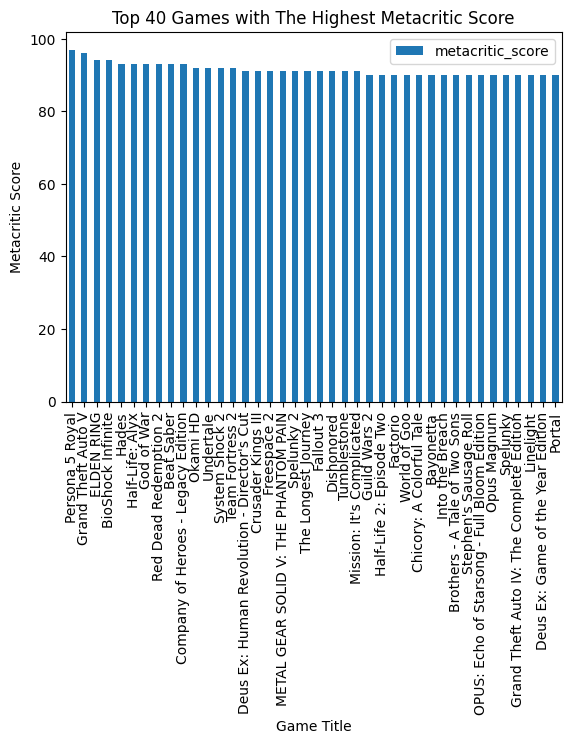

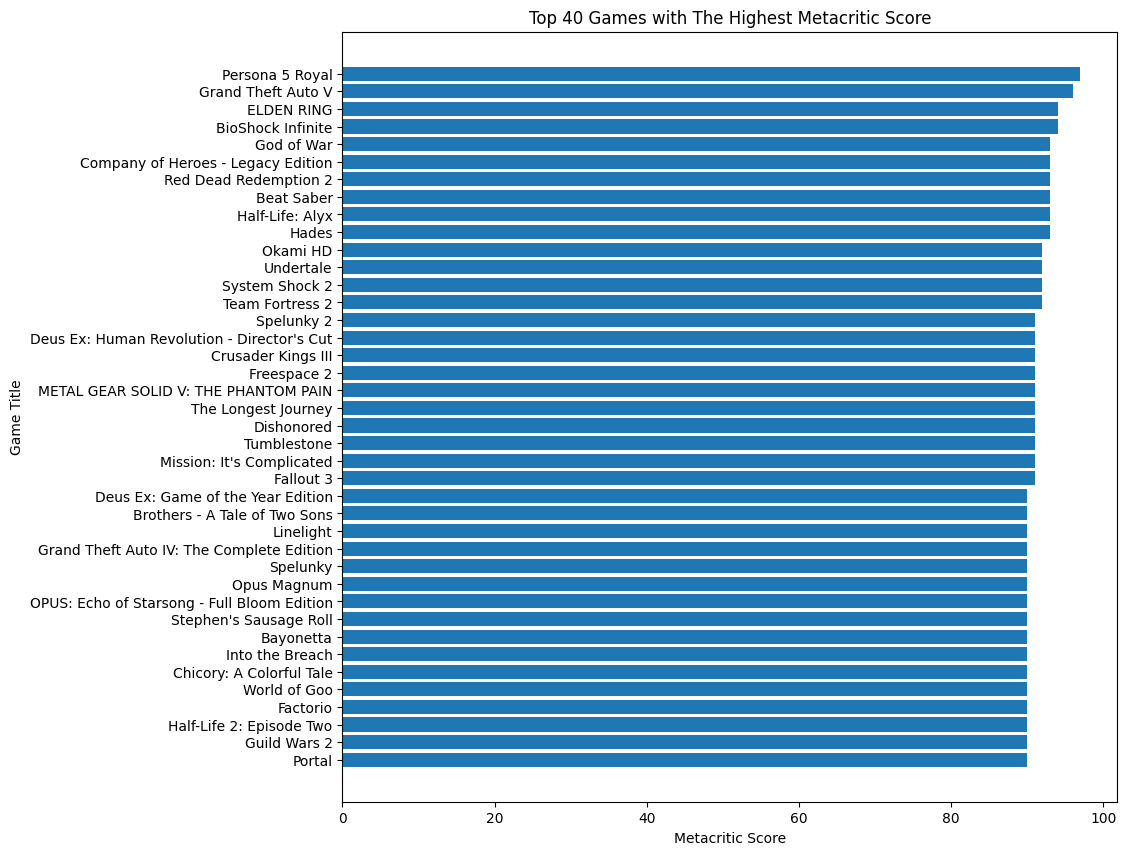

In [ ]:
# Show Top 40 Games with the Highest Metacritic Score
df_games = df_games.sort_values(by='metacritic_score', ascending=False)

# Convert 'metacritic_score' to numeric, handling errors
df_games['metacritic_score'] = pd.to_numeric(df_games['metacritic_score'], errors='coerce')

# Show the plot
df_games.head(40).plot(kind='bar', x='title', y='metacritic_score') # This plot is ok with "title" on the x-axis (categorical)
plt.title('Top 40 Games with The Highest Metacritic Score')
plt.xlabel('Game Title')
plt.ylabel('Metacritic Score')
plt.xticks(rotation=90) # Rotate x-axis labels for better readability
plt.show()

# switch the presentation so that title on y axis and metacritic score on x axis
df_games_top40 = df_games.head(40).sort_values(by=['metacritic_score']) #sorting metacritic_score to have meaningful x axis tick labels
plt.figure(figsize=(10, 10)) #Adjust figure size if titles are cut off
plt.barh(df_games_top40['title'], df_games_top40['metacritic_score']) #Using plt.barh for horizontal bar plot
plt.title('Top 40 Games with The Highest Metacritic Score')
plt.xlabel('Metacritic Score')
plt.ylabel('Game Title')
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


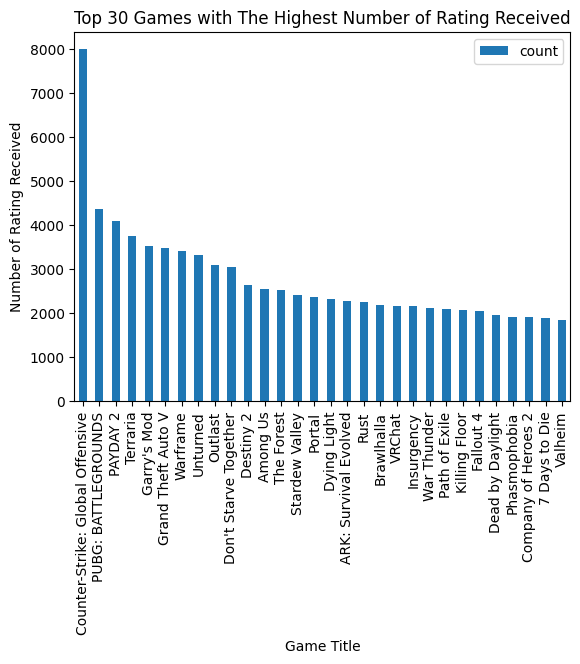

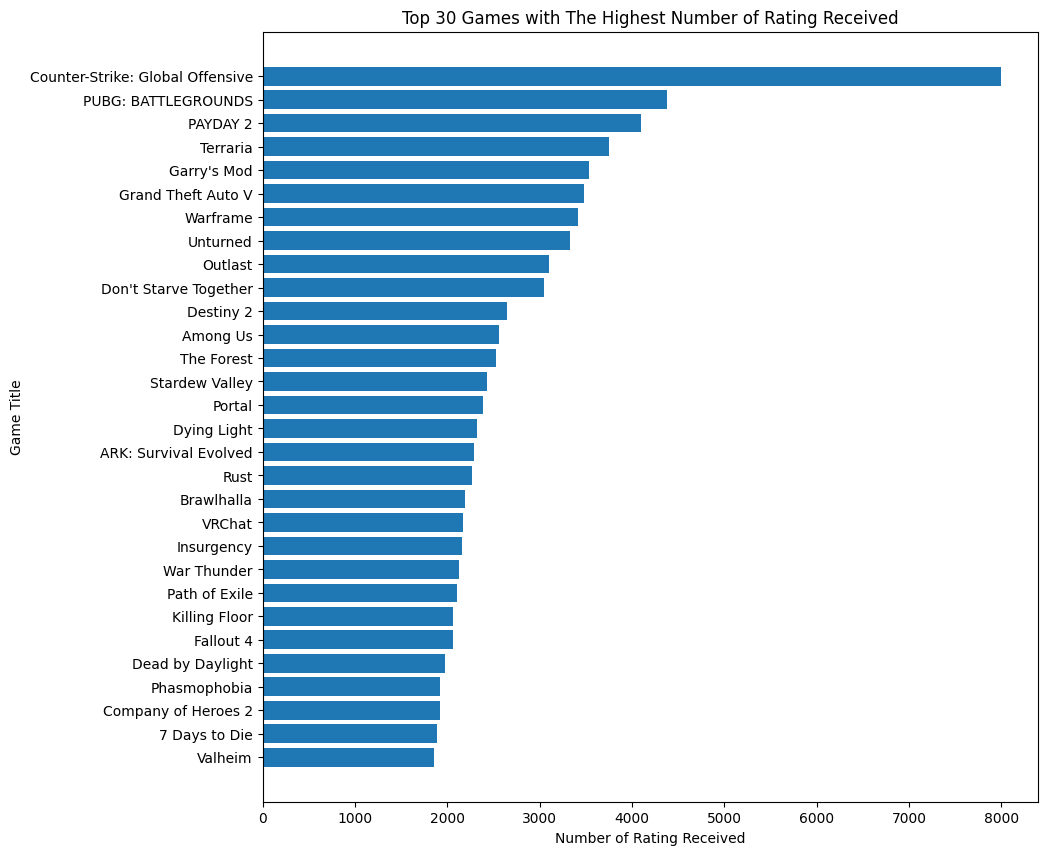

In [ ]:
# Show Top 30 Games with the Highest Number of Rating Received
df_games_users_all_count = df_games_users_all.groupby('title').size().reset_index(name='count')
df_games_users_all_count = df_games_users_all_count.sort_values(by='count', ascending=False)

# Show the plot
df_games_users_all_count.head(30).plot(kind='bar', x='title', y='count')
plt.title('Top 30 Games with The Highest Number of Rating Received')
plt.xlabel('Game Title')
plt.ylabel('Number of Rating Received')
plt.show()

# switch the presentation so that title on y axis and number of rating received on x axis
df_games_users_all_count_top30 = df_games_users_all_count.head(30).sort_values(by=['count'])
plt.figure(figsize=(10, 10))
plt.barh(df_games_users_all_count_top30['title'], df_games_users_all_count_top30['count'])
plt.title('Top 30 Games with The Highest Number of Rating Received')
plt.xlabel('Number of Rating Received')
plt.ylabel('Game Title')
plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


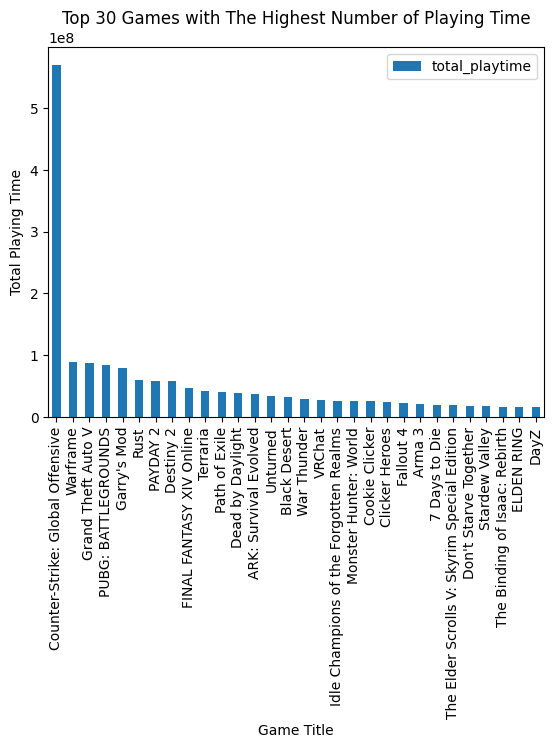

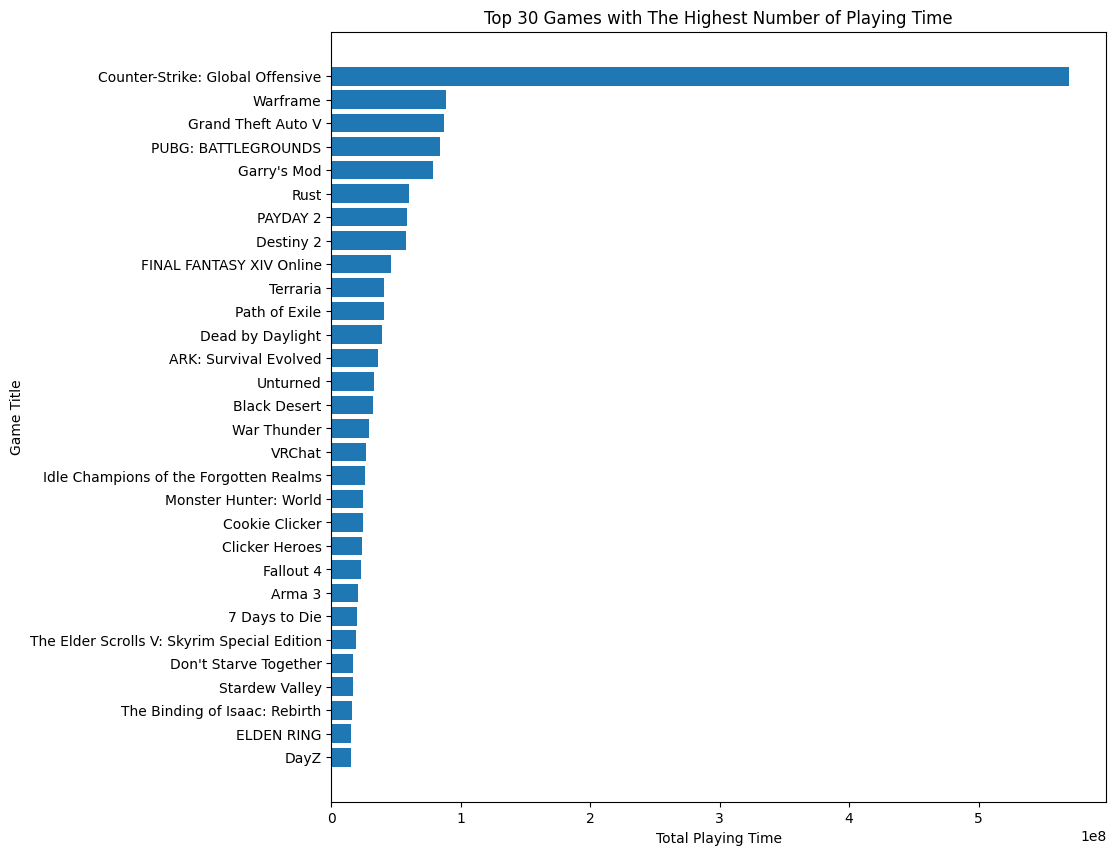

In [ ]:
# Show Top 30 Games with the Highest Number of Playing Time

# Combine total_playtime for each title
df_games_users_all_playtime = df_games_users_all.groupby('title')['total_playtime'].sum().reset_index() # Added parentheses here

# Sort based on the highest total_playtime
df_games_users_all_playtime = df_games_users_all_playtime.sort_values(by='total_playtime', ascending=False)

# Show the plot
df_games_users_all_playtime.head(30).plot(kind='bar', x='title', y='total_playtime')
plt.title('Top 30 Games with The Highest Number of Playing Time')
plt.xlabel('Game Title')
plt.ylabel('Total Playing Time')
plt.show()

# switch the presentation so that title on y axis and total playing time on x axis
df_games_users_all_playtime_top30 = df_games_users_all_playtime.head(30).sort_values(by=['total_playtime'])
plt.figure(figsize=(10, 10))
plt.barh(df_games_users_all_playtime_top30['title'], df_games_users_all_playtime_top30['total_playtime'])
plt.title('Top 30 Games with The Highest Number of Playing Time')
plt.xlabel('Total Playing Time')
plt.ylabel('Game Title')
plt.show()

# Recommendation #1 - Content Base Filtering based on 1 category (title)

The recommendation model utilizes a content-based filtering approach to suggest video games similar to a given game. It begins by creating a TF-IDF (Term Frequency-Inverse Document Frequency) vectorizer to transform the game titles into numerical vectors, effectively capturing the importance of words within the titles. The model then calculates the cosine similarity matrix, which measures the similarity between these vectors. By creating indices of game names, the model can efficiently retrieve the index of the input game and compute its similarity scores with all other games. The similarity scores are sorted, and the top 10 games with the highest scores are selected as recommendations. This approach ensures that the recommended games share similar attributes with the input game, providing users with personalized and relevant suggestions.

In [ ]:
def recommendations(dataframe, title_col, game_name):
    # Create the TF-IDF vectorizer and transform the titles in the dataframe
    tfidf = TfidfVectorizer(stop_words="english")
    tfidf_matrix = tfidf.fit_transform(dataframe[title_col])

    # Calculate the cosine similarity matrix
    cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

    # Create indices of game names in the database
    indices = pd.Series(dataframe.index, index=dataframe[title_col]).drop_duplicates()

    # Get the index of the input game
    idx = indices[game_name]

    # Get the similarity scores of the game
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the similarity scores by game name
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the top 10 games with the highest similarity scores
    sim_scores = sim_scores[1:11]

    # Get the game indices according to the scores
    game_indices = [i[0] for i in sim_scores]

    # Return the relevant games
    return dataframe['title'].iloc[game_indices]

# Call the function
recommendations_list = recommendations(df_games, "title", "Grand Theft Auto V")
print(recommendations_list)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


13275                 Roads of Rome: New Generation
20217               Roads of Rome: New Generation 2
13961    Roads Of Rome: Portals Collector's Edition
30                                    Roads of Rome
17017                               Roads of Rome 3
24635                               Roads of Rome 2
23203                     Last Generation: Survival
22329                                       VR Rome
17541                               D/Generation HD
29952                                 The Collector
Name: title, dtype: category
Categories (30662, object): ['! That Bastard Is Trying To Steal Our Gold !', '!LABrpgUP!', '#AkiRobots', '#Archery', ..., 'xDasher',
                             'zzzzz', '{Undefined}', '~necromancy~Emily's Escape']


# Recommendation #2 - Content Base Filtering based on 2 categories (genres and rating_score)

The content-based recommendation model leverages both genres and rating scores to suggest video games similar to a given title. Initially, the model converts the genres into a TF-IDF (Term Frequency-Inverse Document Frequency) matrix, which captures the importance of genre terms within the dataset. It then computes the cosine similarity between these genre vectors. Simultaneously, the rating scores are normalized to ensure they are on a comparable scale. The model combines the genre similarity and normalized rating scores using specified weights, creating a comprehensive similarity matrix. By identifying the index of the target game and calculating its similarity scores with other games, the model generates a list of recommendations. These recommendations are filtered to exclude duplicates and games already rated by the user, and are sorted by similarity score to present the top suggestions. This approach ensures that the recommended games share similar genres and rating profiles with the input game, providing users with personalized and relevant suggestions.

# Note: Must use Kaggle due to RAM limitation

In [ ]:
# NOTE: Google Colab will not have enough RAM to run this - use Kaggle
# Content based recommendation based on Genres and Rating Score
def content_based_recommendation(game_title, df, genre_weight=0.5, rating_score_weight=0.5, similarity_threshold=0.6):
    # Convert 'genres' to string before applying TF-IDF
    df['genres'] = df['genres'].astype(str)

    # Create a TF-IDF matrix for genres
    tfidf_genres = TfidfVectorizer(stop_words='english')
    tfidf_matrix_genres = tfidf_genres.fit_transform(df['genres'])

    # Compute cosine similarity for genres
    cosine_sim_genres = cosine_similarity(tfidf_matrix_genres, tfidf_matrix_genres)

    # Normalize the rating_score
    df['rating_score_norm'] = (df['rating_score'] - df['rating_score'].min()) / (df['rating_score'].max() - df['rating_score'].min())

    # Combine similarities with weights
    similarity_matrix = (cosine_sim_genres * genre_weight) + (df['rating_score_norm'].values.reshape(-1, 1) * rating_score_weight)

    # Get the index of the target game title
    idx = df[df['title'] == game_title].index
    if len(idx) == 0:
        print(f"Game title '{game_title}' not found in the dataset.")
        return []
    else:
        idx = idx[0]

    # Remove duplicates and games already rated by the user
    rated_games = set([game_title])
    recommendations = []
    for i, score in enumerate(similarity_matrix[idx]):  # Iterate through the similarity scores
        if i != idx and df['title'].iloc[i] not in rated_games and score > similarity_threshold:
            recommendations.append((df['title'].iloc[i], score))
            rated_games.add(df['title'].iloc[i])

    # Sort recommendations by similarity score
    recommendations = sorted(recommendations, key=lambda x: x[1], reverse=True)[:10]  # Top 5 recommendations

    return recommendations

# Test the recommendation engine (assuming df_games is defined with 'genres' and 'rating_score' columns)
game_titles = ['Grand Theft Auto V']
for game_title in game_titles:
    print(f"Recommendations for game title '{game_title}':")
    recommendations = content_based_recommendation(game_title, df_games)
    for title, score in recommendations:
        print(f"- {title} (Similarity Score: {score:.2f})")

# Recommendation #3 - Content Base Filtering based on 3 categories with Annoy

The content-based recommendation model leverages genres, rating scores, and Metacritic scores to suggest video games similar to a given title. Initially, the model converts the genres into a TF-IDF (Term Frequency-Inverse Document Frequency) matrix, capturing the importance of genre terms within the dataset. It then normalizes the rating and Metacritic scores to ensure they are on a comparable scale. These features are combined into a single matrix, which is used to create an Annoy (Approximate Nearest Neighbors Oh Yeah) index. Annoy efficiently handles large, sparse vector spaces, making it ideal for this application. By identifying the index of the target game and calculating its similarity scores with other games, the model generates a list of recommendations. These recommendations are filtered to exclude the target game and those with similarity scores below a specified threshold, ensuring a diverse and relevant selection. This approach integrates multiple aspects of game attributes, providing users with personalized and accurate suggestions.

In [ ]:
# Content-Based Recommendation based on genres, rating score, and metacritic score with Annoy
def content_based_recommendation(game_title, df, genre_weight=0.3, rating_score_weight=0.3, metacritic_score_weight=0.4, similarity_threshold=0.6):
    # Convert 'genres' to string before applying TF-IDF
    df['genres'] = df['genres'].astype(str)

    # Create a TF-IDF matrix for genres
    tfidf_genres = TfidfVectorizer(stop_words='english')
    tfidf_matrix_genres = tfidf_genres.fit_transform(df['genres'])

    # Convert 'rating_score' and 'metacritic_score' to numeric and normalize
    df['rating_score'] = pd.to_numeric(df['rating_score'], errors='coerce')
    df['metacritic_score'] = pd.to_numeric(df['metacritic_score'], errors='coerce')

    df['rating_score_norm'] = (df['rating_score'] - df['rating_score'].min()) / (df['rating_score'].max() - df['rating_score'].min())
    df['metacritic_score_norm'] = (df['metacritic_score'] - df['metacritic_score'].min()) / (df['metacritic_score'].max() - df['metacritic_score'].min())

    # Combine features into a single matrix
    combined_features = np.hstack([
        tfidf_matrix_genres.toarray() * genre_weight,
        df['rating_score_norm'].values.reshape(-1, 1) * rating_score_weight,
        df['metacritic_score_norm'].values.reshape(-1, 1) * metacritic_score_weight
    ])

    # Create Annoy index
    f = combined_features.shape[1]
    t = AnnoyIndex(f, 'angular')

    for i in range(len(combined_features)):
        t.add_item(i, combined_features[i])

    t.build(10)  # 10 trees

    # Get the index of the target game title
    idx = df[df['title'] == game_title].index
    if len(idx) == 0:
        print(f"Game title '{game_title}' not found in the dataset.")
        return []
    else:
        idx = idx[0]

    # Get similar items
    similar_items = t.get_nns_by_item(idx, 11, include_distances=True)

    recommendations = [(df['title'].iloc[i], 1 - dist) for i, dist in zip(similar_items[0], similar_items[1]) if i != idx and 1 - dist > similarity_threshold]

    return recommendations

# Test the recommendation engine (assuming df_games is defined with 'genres', 'rating_score', and 'metacritic_score' columns)
game_titles = ['Grand Theft Auto V']
for game_title in game_titles:
    print(f"Recommendations for game title '{game_title}':")
    recommendations = content_based_recommendation(game_title, df_games)
    for title, score in recommendations:
        print(f"- {title} (Similarity Score: {score:.2f})")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Recommendations for game title 'Grand Theft Auto V':
- Viking Saga: The Cursed Ring (Similarity Score: 1.00)
- Viking Saga: New World (Similarity Score: 1.00)
- Northern Tale 2 (Similarity Score: 0.99)
- MOAI 2: Path to Another World (Similarity Score: 0.99)
- Viking Saga: Epic Adventure (Similarity Score: 0.99)
- Northern Tale 4 (Similarity Score: 0.99)
- MEGALOMANIAC (Similarity Score: 0.98)
- Northern Tale 3 (Similarity Score: 0.98)
- Roads of Rome (Similarity Score: 0.97)
- Adelantado Trilogy. Book Two (Similarity Score: 0.97)


# Recommendation #4 - Content Base Filtering based on 4 categories with Annoy

This content-based filtering recommendation system leverages game features like genres, user ratings, rating scores, and Metacritic scores to suggest similar games. It employs TF-IDF to represent game genres numerically and normalizes rating scores and Metacritic scores for comparability. User ratings are encoded and normalized as well. These features are combined into a single vector for each game. Annoy, an approximate nearest neighbor search library, is used to efficiently find games with similar feature vectors, providing recommendations based on content similarity to the target game. This approach offers personalized suggestions by focusing on inherent game attributes that align with user preferences.

In [ ]:
# Content-Based Recommendation based on genres, rating, rating score, and metacritic score with Annoy
def content_based_recommendation(game_title, df, genre_weight=0.25, rating_weight=0.25, rating_score_weight=0.25, metacritic_score_weight=0.25, similarity_threshold=0.6):
    # Convert 'genres' to string before applying TF-IDF
    df['genres'] = df['genres'].astype(str)

    # Create a TF-IDF matrix for genres
    tfidf_genres = TfidfVectorizer(stop_words='english')
    tfidf_matrix_genres = tfidf_genres.fit_transform(df['genres'])

    # Convert 'rating_score' and 'metacritic_score' to numeric and normalize
    df['rating_score'] = pd.to_numeric(df['rating_score'], errors='coerce')
    df['metacritic_score'] = pd.to_numeric(df['metacritic_score'], errors='coerce')

    df['rating_score_norm'] = (df['rating_score'] - df['rating_score'].min()) / (df['rating_score'].max() - df['rating_score'].min())
    df['metacritic_score_norm'] = (df['metacritic_score'] - df['metacritic_score'].min()) / (df['metacritic_score'].max() - df['metacritic_score'].min())

    # --- Incorporating 'rating' ---
    # 1. Convert 'rating' to numerical representation using Label Encoding
    le = LabelEncoder()
    df['rating_encoded'] = le.fit_transform(df['rating'])

    # 2. Normalize the encoded rating
    df['rating_encoded_norm'] = (df['rating_encoded'] - df['rating_encoded'].min()) / (df['rating_encoded'].max() - df['rating_encoded'].min())

    # Combine features into a single matrix, including the encoded rating
    combined_features = np.hstack([
        tfidf_matrix_genres.toarray() * genre_weight,
        df['rating_encoded_norm'].values.reshape(-1, 1) * rating_weight,  # Added encoded rating
        df['rating_score_norm'].values.reshape(-1, 1) * rating_score_weight,
        df['metacritic_score_norm'].values.reshape(-1, 1) * metacritic_score_weight
    ])

    # Create Annoy index
    f = combined_features.shape[1]
    t = AnnoyIndex(f, 'angular')

    for i in range(len(combined_features)):
        t.add_item(i, combined_features[i])

    t.build(10)  # 10 trees

    # Get the index of the target game title
    idx = df[df['title'] == game_title].index
    if len(idx) == 0:
        print(f"Game title '{game_title}' not found in the dataset.")
        return []
    else:
        idx = idx[0]

    # Get similar items
    similar_items = t.get_nns_by_item(idx, 11, include_distances=True)

    recommendations = [(df['title'].iloc[i], 1 - dist) for i, dist in zip(similar_items[0], similar_items[1]) if i != idx and 1 - dist > similarity_threshold]

    return recommendations

# Test the recommendation engine (assuming df_games is defined with 'genres', 'rating_score', and 'metacritic_score' columns)
game_titles = ['Grand Theft Auto V']
for game_title in game_titles:
    print(f"Recommendations for game title '{game_title}':")
    recommendations = content_based_recommendation(game_title, df_games)
    for title, score in recommendations:
        print(f"- {title} (Similarity Score: {score:.2f})")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Recommendations for game title 'Grand Theft Auto V':
- Viking Saga: The Cursed Ring (Similarity Score: 1.00)
- Viking Saga: New World (Similarity Score: 1.00)
- Northern Tale 2 (Similarity Score: 1.00)
- Viking Saga: Epic Adventure (Similarity Score: 0.99)
- Northern Tale 4 (Similarity Score: 0.99)
- MEGALOMANIAC (Similarity Score: 0.99)
- Northern Tale 3 (Similarity Score: 0.98)
- Adelantado Trilogy. Book Two (Similarity Score: 0.97)
- Adelantado Trilogy. Book Three (Similarity Score: 0.97)
- Adelantado Trilogy. Book one (Similarity Score: 0.94)


# Recommendation #5 - Collaborative Filtering based on 1 category (total_playtime)

The collaborative filtering recommendation model leverages user-item interactions to suggest video games. It begins by creating a user-item matrix, where each cell represents the total playtime of a user for a specific game. Missing values are filled with zeros to indicate no interaction. The model then calculates the cosine similarity between users, generating a user-user similarity matrix. By identifying the top N most similar users to the target user, the model can recommend games that these similar users have enjoyed. The recommendations are filtered to remove duplicates and limited to the top 20 suggestions. This approach ensures that the recommended games are based on the preferences and behaviors of users with similar tastes, providing personalized and relevant suggestions.

In [ ]:
# Collaborative Filtering using User-Item Interactions
def collaborative_filtering_recommendation(user_id, df):
  # Create the user-item matrix
  user_item_matrix = pd.pivot_table(df, values='total_playtime', index='user_id', columns='title', fill_value=0)
  print(user_item_matrix)

  # Fill missing values with 0 (indicating no rating)
  user_item_matrix = user_item_matrix.fillna(0)
  print(user_item_matrix)

  # Calculate user-user similarity matrix using cosine similarity
  user_similarity = cosine_similarity(user_item_matrix)
  print(user_similarity)

  # Get the similarity scores of the target user with all other users
  user_similarity_scores = user_similarity[user_id]
  print(user_similarity_scores)

  # Find the top N most similar users (excluding the target user)
  N = 5
  top_similar_users = np.argsort(user_similarity_scores)[::-1][1:N+1]
  print(top_similar_users)

  # Generate movie recommendations based on the most similar users
  recommendations = []
  for user in top_similar_users:
    recommendations.extend(df[df['user_id'] == user]['title'].values)
  print(recommendations)

  # Remove duplicates from recommendations
  recommendations = list(set(recommendations))

  # Limit to 20 recommendations
  recommendations = recommendations[:20]

  return recommendations

# Test the recommendation engines
user_ids = [1, 2, 3]
for user_id in user_ids:
    print(f"Recommendations for user {user_id}:")
    recommendations = collaborative_filtering_recommendation(user_id, df_games_users_all)
    for i, recommendation in enumerate(recommendations, 1):
        print(f"{i}. {recommendation}")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Recommendations for user 1:
title    ! That Bastard Is Trying To Steal Our Gold !  #CuteSnake  \
user_id                                                             
1                                                 0.0         0.0   
2                                                 0.0         0.0   
3                                                 0.0         0.0   
4                                                 0.0         0.0   
5                                                 0.0         0.0   
...                                               ...         ...   
9996                                              0.0         0.0   
9997                                              0.0         0.0   
9998                                              0.0         0.0   
9999                                              0.0         0.0   
10000                                             0.0         0.0   

title    #CuteSnake 2  #KILLALLZOMBIES  #monstercakes  $1 Ride  \
user_id 

# Recommendation #6 - Collaborative Filtering based on 3 categories (rating, rating_score and total_playtime)

The collaborative filtering recommendation model utilizes user-item interactions across multiple categories, specifically rating and total playtime, to suggest video games. Initially, the model maps string-based ratings to numerical scores and normalizes both the rating scores and total playtime. These normalized values are combined into a single score, which is used to create a user-item matrix. By calculating the cosine similarity between users, the model generates a user-user similarity matrix. The similarity scores of the target user with all other users are then used to identify the top N most similar users. Recommendations are generated based on the games enjoyed by these similar users, ensuring a diverse and personalized selection. This approach effectively integrates multiple aspects of user preferences, providing robust and accurate game recommendations.

In [ ]:
# Collaborative Filtering using User-Item Interactions with multiple categories (rating and total_playtime)
def collaborative_filtering_recommendation(user_id, df):
    # Define a mapping for string ratings to numerical scores
    rating_mapping = {
        'Overwhelmingly Positive': 5,
        'Very Positive': 4,
        'Positive': 3,
        'Mostly Positive': 2,
        'Mixed': 1,
        'Mostly Negative': 0,
        'Negative': -1,
        'Very Negative': -2,
        'Overwhelmingly Negative': -3
    }

    # Map string ratings to numerical scores
    df['rating_score'] = df['rating'].map(rating_mapping)

    # Handle cases where the rating is not in the mapping (optional)
    df['rating_score'] = pd.to_numeric(df['rating_score'], errors='coerce')
    df['rating_score'] = df['rating_score'].fillna(df['rating_score'].mean())  # Or any suitable strategy

    # Normalize 'total_playtime' and 'rating_score'
    df['total_playtime_norm'] = (df['total_playtime'] - df['total_playtime'].min()) / (df['total_playtime'].max() - df['total_playtime'].min())
    df['rating_score_norm'] = (df['rating_score'] - df['rating_score'].min()) / (df['rating_score'].max() - df['rating_score'].min())

    # Create a combined score
    df['combined_score'] = df['total_playtime_norm'] * 0.5 + df['rating_score_norm'] * 0.5

    # Create the user-item matrix using the combined score
    user_item_matrix = pd.pivot_table(df, values='combined_score', index='user_id', columns='title', fill_value=0)

    # Calculate user-user similarity matrix using cosine similarity
    user_similarity = cosine_similarity(user_item_matrix)

    # Get the similarity scores of the target user with all other users
    user_similarity_scores = user_similarity[user_id - 1]  # Adjust index if user_id starts from 1

    # Find the top N most similar users (excluding the target user)
    N = 5
    top_similar_users = np.argsort(user_similarity_scores)[::-1][1:N + 1]

    # Generate movie recommendations based on the most similar users
    recommendations = []
    for user_index in top_similar_users:
        user_id_similar = user_item_matrix.index[user_index]
        recommendations.extend(df[df['user_id'] == user_id_similar]['title'].values)

    # Remove duplicates from recommendations
    recommendations = list(set(recommendations))

    # Limit to 20 recommendations
    recommendations = recommendations[:20]

    return recommendations

# Test the recommendation engines
user_ids = [1, 2, 3]
for user_id in user_ids:
    print(f"Recommendations for user {user_id}:")
    recommendations = collaborative_filtering_recommendation(user_id, df_games_users_all)
    for i, recommendation in enumerate(recommendations, 1):
        print(f"{i}. {recommendation}")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Recommendations for user 1:
1. The Longest Journey
2. Monster Loves You!
3. Contrast
4. Scoregasm
5. Beat Saber
6. Keebles
7. Gish
8. Orb of Creation
9. Lara Croft and the Guardian of Light
10. Obduction
11. Papo & Yo
12. Pony Island
13. Griftlands
14. Braid
15. Hacknet
16. Days Gone
17. Desperados III
18. Acron: Attack of the Squirrels!
19. Wasteland Angel
20. Heretic: Shadow of the Serpent Riders
Recommendations for user 2:
1. Jurassic World Evolution
2. Zombie Army Trilogy
3. METAL GEAR SURVIVE
4. Yoku's Island Express
5. Beat Saber
6. Myst
7. The Case of the Golden Idol
8. Avalanche 2: Super Avalanche
9. Obduction
10. Blasphemous
11. Nobody Saves the World
12. Blade Symphony
13. Democracy 3
14. Griftlands
15. Braid
16. Hacknet
17. Elite Dangerous
18. Salt and Sanctuary
19. Regions Of Ruin
20. Furi
Recommendations for user 3:
1. Palindrome Syndrome: Escape Room
2. Townsmen VR
3. Monster Loves You!
4. Legend of Dungeon
5. Pikuniku
6. Yoku's Island Express
7. Beat Saber
8. Highlands
9

# Recommendation #7 - Collaborative Filtering based on 3 categories (rating, rating_score, and total_playtime) with only the top 5 of the highest playing_time for each user

The collaborative filtering recommendation model utilizes user-item interactions across multiple categories, specifically rating and total playtime, to suggest video games. Initially, the model maps string-based ratings to numerical scores and normalizes both the rating scores and total playtime. These normalized values are combined into a single score, which is used to create a user-item matrix. By calculating the cosine similarity between users, the model generates a user-user similarity matrix. The similarity scores of the target user with all other users are then used to identify the top N most similar users. Recommendations are generated based on the games enjoyed by these similar users, ensuring a diverse and personalized selection. This approach effectively integrates multiple aspects of user preferences, providing robust and accurate game recommendations.

In [ ]:
# Function to get the top 5 highest playing time for each user_id
def top_5_playtime(group):
    return group.nlargest(5, 'total_playtime')

# Apply the function to each group of user_id
top_5_playtime_all_users = df_users.groupby('user_id', group_keys=False).apply(top_5_playtime).reset_index(drop=True)

# Display the result
print(top_5_playtime_all_users.head())

# Merge df_games and df_users dataframes
df_games_users_top_5 = pd.merge(df_games[['app_id', 'title', 'genres', 'rating', 'rating_score']], top_5_playtime_all_users, on='app_id')
df_games_users_top_5 = df_games_users_top_5[['user_id', 'title', 'genres', 'rating', 'rating_score', 'total_playtime']]

# Sort by user_id
df_games_users_top_5 = df_games_users_top_5.sort_values(by='user_id')

# Display the result
print(df_games_users_top_5.head(20))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


   user_id   app_id  total_playtime
0        1   271590           42970
1        1   377160           22048
2        1   365590           13161
3        1  1174180           13106
4        1   292030           12750
       user_id                  title  \
24           1     Grand Theft Auto V   
1704         1  Red Dead Redemption 2   
5151         1              Fallout 4   
24707        2   Dyson Sphere Program   
29345        2         Clicker Heroes   
1401         2             ELDEN RING   
2058         2               Factorio   
18940        3           No Man's Sky   
13207        4            War Thunder   
23213        4              ASTRONEER   
12383        4              Destiny 2   
17306        5               Warframe   
12384        5              Destiny 2   
4029         5          Path of Exile   
5120         6           Just Cause 2   
20187        6       Walking Zombie 2   
2204         6            Left 4 Dead   
24708        7   Dyson Sphere Program   
2059 

<ipython-input-37-a2ce6e24bf99>:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_5_playtime_all_users = df_users.groupby('user_id', group_keys=False).apply(top_5_playtime).reset_index(drop=True)


In [ ]:
# Collaborative Filtering using User-Item Interactions with multiple categories (rating and total_playtime)
def collaborative_filtering_recommendation(user_id, df):
    # Define a mapping for string ratings to numerical scores
    rating_mapping = {
        'Overwhelmingly Positive': 5,
        'Very Positive': 4,
        'Positive': 3,
        'Mostly Positive': 2,
        'Mixed': 1,
        'Mostly Negative': 0,
        'Negative': -1,
        'Very Negative': -2,
        'Overwhelmingly Negative': -3
    }

    # Map string ratings to numerical scores
    df['rating_score'] = df['rating'].map(rating_mapping)

    # Handle cases where the rating is not in the mapping (optional)
    df['rating_score'] = pd.to_numeric(df['rating_score'], errors='coerce')
    df['rating_score'] = df['rating_score'].fillna(df['rating_score'].mean())  # Or any suitable strategy

    # Normalize 'total_playtime' and 'rating_score'
    df['total_playtime_norm'] = (df['total_playtime'] - df['total_playtime'].min()) / (df['total_playtime'].max() - df['total_playtime'].min())
    df['rating_score_norm'] = (df['rating_score'] - df['rating_score'].min()) / (df['rating_score'].max() - df['rating_score'].min())

    # Create a combined score
    df['combined_score'] = df['total_playtime_norm'] * 0.5 + df['rating_score_norm'] * 0.5

    # Create the user-item matrix using the combined score
    user_item_matrix = pd.pivot_table(df, values='combined_score', index='user_id', columns='title', fill_value=0)

    # Calculate user-user similarity matrix using cosine similarity
    user_similarity = cosine_similarity(user_item_matrix)

    # Get the similarity scores of the target user with all other users
    user_similarity_scores = user_similarity[user_id - 1]  # Adjust index if user_id starts from 1

    # Find the top N most similar users (excluding the target user)
    N = 5
    top_similar_users = np.argsort(user_similarity_scores)[::-1][1:N + 1]

    # Generate movie recommendations based on the most similar users
    recommendations = []
    for user_index in top_similar_users:
        user_id_similar = user_item_matrix.index[user_index]
        recommendations.extend(df[df['user_id'] == user_id_similar]['title'].values)

    # Remove duplicates from recommendations
    recommendations = list(set(recommendations))

    # Limit to 20 recommendations
    recommendations = recommendations[:20]

    return recommendations

# Test the recommendation engines
user_ids = [10, 20, 30]
for user_id in user_ids:
    print(f"Recommendations for user {user_id}:")
    recommendations = collaborative_filtering_recommendation(user_id, df_games_users_top_5)
    for i, recommendation in enumerate(recommendations, 1):
        print(f"{i}. {recommendation}")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-38-abdca065ab98>:31: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  user_item_matrix = pd.pivot_table(df, values='combined_score', index='user_id', columns='title', fill_value=0)


Recommendations for user 10:
1. Counter-Strike: Global Offensive
2. Neverwinter
3. Left 4 Dead
4. Black Squad
5. LoveBeat
Recommendations for user 20:


<ipython-input-38-abdca065ab98>:31: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  user_item_matrix = pd.pivot_table(df, values='combined_score', index='user_id', columns='title', fill_value=0)


1. Head Goal: Soccer Online
2. Ball 3D: Soccer Online
3. Russian Life Simulator
4. Counter-Strike: Global Offensive
5. PUBG: BATTLEGROUNDS
6. Road Scars: Origins
Recommendations for user 30:


<ipython-input-38-abdca065ab98>:31: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  user_item_matrix = pd.pivot_table(df, values='combined_score', index='user_id', columns='title', fill_value=0)


1. Fistful of Frags
2. Dead by Daylight
3. Stardew Valley
4. Lunch Lady
5. Geometry Dash
6. No Man's Sky
7. Terraria
8. Planet Coaster


# Recommendation #8 - Hybrid Model based on 4 categories (genres, rating, rating_score, and total_playtime) with only the top 10 of the highest playing_time for each user

The hybrid recommendation model combines user-item interactions across multiple categories, including ratings, genres, and total playtime, to suggest video games. Initially, the model maps string-based ratings to numerical scores and normalizes both the rating scores and total playtime. It then creates a TF-IDF (Term Frequency-Inverse Document Frequency) matrix for game genres. These features are combined into a single DataFrame, which is used to construct a user-item matrix. By calculating the cosine similarity between users, the model generates a user-user similarity matrix. The similarity scores of the target user with all other users are then used to identify the top N most similar users. Recommendations are generated based on the games enjoyed by these similar users, ensuring a diverse and personalized selection. This approach effectively integrates content-based filtering (using genres and ratings) with collaborative filtering (using user similarities), resulting in a robust and comprehensive recommendation system.

# Must use Kaggle due to RAM limitation

In [ ]:
# Function to get the top 10 highest playing time for each user_id
def top_10_playtime(group):
    return group.nlargest(10, 'total_playtime')

# Apply the function to each group of user_id
top_10_playtime_all_users = df_users.groupby('user_id', group_keys=False).apply(top_10_playtime).reset_index(drop=True)

# Display the result
print(top_10_playtime_all_users.head())

# Merge df_games and df_users dataframes
df_games_users_top_10 = pd.merge(df_games[['app_id', 'title', 'genres', 'rating', 'rating_score']], top_10_playtime_all_users, on='app_id')
df_games_users_top_10 = df_games_users_top_10[['user_id', 'title', 'genres', 'rating', 'rating_score', 'total_playtime']]

# Sort by user_id
df_games_users_top_10 = df_games_users_top_10.sort_values(by='user_id')

# Display the result
print(df_games_users_top_10.head(20))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


   user_id   app_id  total_playtime
0        1   271590           42970
1        1   377160           22048
2        1   365590           13161
3        1  1174180           13106
4        1   292030           12750
       user_id                                      title  \
10115        1                                  Fallout 4   
37930        1                                 Fallout 76   
3985         1  Grand Theft Auto IV: The Complete Edition   
2910         1                      Red Dead Redemption 2   
59           1                         Grand Theft Auto V   
20934        2                           The Outer Worlds   
44197        2                       Dyson Sphere Program   
53796        2                             Clicker Heroes   
10114        2                                  SpaceChem   
7024         2                                 Subnautica   
2095         2                                 ELDEN RING   
3776         2                                   Fac

<ipython-input-39-3dede5966c03>:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_10_playtime_all_users = df_users.groupby('user_id', group_keys=False).apply(top_10_playtime).reset_index(drop=True)


In [ ]:
# NOTE: Google Colab will not have enough RAM to run this - use Kaggle
# Hybrid Model using User-Item Interactions with multiple categories (rating, genres, and total_playtime)
def hybrid_model_recommendation(user_id, df):
    # Define a mapping for string ratings to numerical scores
    rating_mapping = {
        'Overwhelmingly Positive': 5,
        'Very Positive': 4,
        'Positive': 3,
        'Mostly Positive': 2,
        'Mixed': 1,
        'Mostly Negative': 0,
        'Negative': -1,
        'Very Negative': -2,
        'Overwhelmingly Negative': -3
    }

    # Map string ratings to numerical scores
    df['rating_score'] = df['rating'].map(rating_mapping)

    # Handle cases where the rating is not in the mapping (optional)
    df['rating_score'] = pd.to_numeric(df['rating_score'], errors='coerce')
    df['rating_score'] = df['rating_score'].fillna(df['rating_score'].mean())  # Or any suitable strategy

    # Normalize 'total_playtime' and 'rating_score'
    df['total_playtime_norm'] = (df['total_playtime'] - df['total_playtime'].min()) / (df['total_playtime'].max() - df['total_playtime'].min())
    df['rating_score_norm'] = (df['rating_score'] - df['rating_score'].min()) / (df['rating_score'].max() - df['rating_score'].min())

    # Create a TF-IDF matrix for genres
    tfidf_genres = TfidfVectorizer(stop_words='english')
    df['genres'] = df['genres'].fillna('')  # Fill NaN values with empty string
    tfidf_matrix_genres = tfidf_genres.fit_transform(df['genres'])

    # Combine normalized scores and genres into a single DataFrame
    df_combined = pd.DataFrame({
        'total_playtime_norm': df['total_playtime_norm'],
        'rating_score_norm': df['rating_score_norm']
    })

    # Add the TF-IDF matrix for genres to the combined DataFrame
    df_combined = pd.concat([df_combined, pd.DataFrame(tfidf_matrix_genres.toarray(), index=df.index)], axis=1)

    # Create the user-item matrix using the combined score
    user_item_matrix = pd.pivot_table(df_combined, index=df['user_id'], columns=df['title'], fill_value=0)

    # Calculate user-user similarity matrix using cosine similarity
    user_similarity = cosine_similarity(user_item_matrix)

    # Get the similarity scores of the target user with all other users
    user_similarity_scores = user_similarity[user_id - 1]  # Adjust index if user_id starts from 1

    # Find the top N most similar users (excluding the target user)
    N = 5
    top_similar_users = np.argsort(user_similarity_scores)[::-1][1:N + 1]

    # Generate movie recommendations based on the most similar users
    recommendations = []
    for user_index in top_similar_users:
        user_id_similar = user_item_matrix.index[user_index]
        recommendations.extend(df[df['user_id'] == user_id_similar]['title'].values)

    # Remove duplicates from recommendations
    recommendations = list(set(recommendations))

    # Limit to 20 recommendations
    recommendations = recommendations[:20]

    return recommendations

# Test the recommendation engines
user_ids = [10, 20, 30]
for user_id in user_ids:
    print(f"Recommendations for user {user_id}:")
    recommendations = hybrid_model_recommendation(user_id, df_games_users_top_10)
    for i, recommendation in enumerate(recommendations, 1):
        print(f"{i}. {recommendation}")

# Recommendation #9 - Popularity-Based Recommendation

This popularity-based recommendation system suggests games based on their overall engagement metrics, including total playtime, average playtime, and the number of unique players. By merging game and user data, the system calculates these metrics for each game, optionally filtering by a specific genre. A weighted popularity score is then calculated, considering total playtime, average playtime, and the number of players. Games are ranked by this score, and the top-ranked games are recommended to users. This approach provides a straightforward way to identify and suggest widely enjoyed games, potentially catering to broader user preferences.

In [ ]:
def popularity_based_recommendation(df_games, df_users, num_recommendations=10, genre=None):
    # Merge game and user data to calculate total and average playtime
    # Ensure 'genres' column is selected in the merge if it exists
    if 'genres' in df_games.columns:
        df_merged = pd.merge(df_games[['app_id', 'title', 'genres']], df_users, on='app_id')
    else:
        df_merged = pd.merge(df_games[['app_id', 'title']], df_users, on='app_id')

    df_popularity = df_merged.groupby('title').agg(
        total_playtime=('total_playtime', 'sum'),
        avg_playtime=('total_playtime', 'mean'),
        num_players=('user_id', 'nunique'),  # Number of unique players
        genres=('genres', 'first')  # Get the first genre for each title
    ).reset_index()

    # Check if 'genres' column is present and genre is provided before filtering
    if genre and 'genres' in df_popularity.columns:
        df_popularity = df_popularity[df_popularity['genres'].str.contains(genre, case=False, na=False)]

    # Calculate popularity score (you can adjust the weights)
    df_popularity['popularity_score'] = (
        df_popularity['total_playtime'] * 0.5 +  # Weight for total playtime
        df_popularity['avg_playtime'] * 0.3 +    # Weight for average playtime
        df_popularity['num_players'] * 0.2       # Weight for number of players
    )

    # Sort by popularity score and get top recommendations
    df_recommendations = df_popularity.sort_values('popularity_score', ascending=False).head(num_recommendations)

    return df_recommendations['title'].tolist()

# Example usage
recommendations = popularity_based_recommendation(df_games, df_users, genre='RPG')
print("Popular RPG Games:")
for game in recommendations:
    print(game)

recommendations = popularity_based_recommendation(df_games, df_users)  # No genre filter
print("\nOverall Popular Games:")
for game in recommendations:
    print(game)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-57-f89f6ff0e620>:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_popularity = df_merged.groupby('title').agg(


Popular Action Games:
Warframe
Rust
PAYDAY 2
FINAL FANTASY XIV Online
Terraria
Path of Exile
ARK: Survival Evolved
Black Desert
Clicker Heroes
Fallout 4


<ipython-input-57-f89f6ff0e620>:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_popularity = df_merged.groupby('title').agg(



Overall Popular Games:
Counter-Strike: Global Offensive
Warframe
Grand Theft Auto V
PUBG: BATTLEGROUNDS
Garry's Mod
Rust
PAYDAY 2
Destiny 2
FINAL FANTASY XIV Online
Terraria


# Recommendation #10 - Matrix Factorization Model

The code implements a matrix factorization technique for game recommendations using the Alternating Least Squares (ALS) algorithm from the implicit library. It first creates a user-item matrix representing user interactions (total playtime) with games. This matrix is then factorized into two lower-dimensional matrices, one representing user preferences and the other representing game characteristics. The ALS algorithm iteratively optimizes these matrices to minimize the difference between the original matrix and their product. By leveraging these learned representations, the model can predict a user's preference for games they haven't interacted with and generate personalized recommendations. The get_recommendations function utilizes the trained model to provide a specified number of game suggestions for a target user based on their predicted preferences.

In [ ]:
def build_matrix_factorization_model(df_users, df_games, num_factors=50, regularization=0.01, iterations=15):
    # Filter data for users with at least 5 games played
    df_filtered = df_users.groupby('user_id').filter(lambda x: len(x) >= 5)

    # Create a user-item matrix
    user_item_matrix = pd.pivot_table(df_filtered, values='total_playtime', index='user_id', columns='app_id', fill_value=0)

    # Convert the user-item matrix to a sparse matrix
    user_item_matrix_sparse = csr_matrix(user_item_matrix.values)

    # Initialize and train the ALS model
    model = implicit.als.AlternatingLeastSquares(factors=num_factors, regularization=regularization, iterations=iterations)
    model.fit(user_item_matrix_sparse)

    # Create app_id to index mapping
    app_id_to_index = {app_id: index for index, app_id in enumerate(user_item_matrix.columns)}
    index_to_app_id = {index: app_id for app_id, index in app_id_to_index.items()}

    # Return the sparse matrix along with other values
    # Added user_item_matrix to the return statement
    return model, app_id_to_index, index_to_app_id, user_item_matrix_sparse, user_item_matrix

def get_recommendations(user_id, model, user_item_matrix_sparse, index_to_app_id, df_games, user_item_matrix, N=10): # Add user_item_matrix as an argument
    # Find the row index corresponding to user_id in the original user-item matrix
    user_row_index = user_item_matrix.index.get_loc(user_id)

    # Get the user's row from the sparse matrix using the row index
    user_items = user_item_matrix_sparse[user_row_index]

    # Get recommendations
    recommendations_indices, _ = model.recommend(user_id, user_items, N=N)  # user_items as the user's row

    recommendations_app_ids = [index_to_app_id[index] for index in recommendations_indices]
    recommendations_titles = df_games[df_games['app_id'].isin(recommendations_app_ids)]['title'].tolist()
    return recommendations_titles


# Example usage:
# The function returns 5 values, so adjust the variable assignment accordingly
model, app_id_to_index, index_to_app_id, user_item_matrix_sparse, user_item_matrix = build_matrix_factorization_model(df_users, df_games)

# You don't need to call build_matrix_factorization_model twice in this case
# The previous line has already obtained user_item_matrix
# ... rest of your code

recommendations = get_recommendations(1, model, user_item_matrix_sparse, index_to_app_id, df_games, user_item_matrix)
print(f"Recommendations for user 1: {recommendations}")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/15 [00:00<?, ?it/s]

Recommendations for user 1: ['Left 4 Dead', 'Oxygen Not Included', 'Prison Architect', 'WAKFU', 'Neverwinter', 'Killing Floor', 'Tabletop Simulator', 'Phasmophobia', 'VRChat', 'Clicker Heroes']
